In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
test_summary = pd.read_csv('input/signal_summary.csv')
public748 = pd.read_csv('input/public748.csv')
public716 = pd.read_csv('input/public716.csv')

In [4]:
test = pd.concat([test, test_summary.drop('idx', axis=1)], axis=1)

In [5]:
test

,id,target,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
0,00054c878,0.5,1238170136,1248567118,303,4639,36.596880,5.182469,0.648318,0.236532,1238168574,1248561347,324,4566,31.032060,5.172359,0.646489,0.236746
1,0007285a3,0.5,1238168014,1248520149,319,4427,33.348710,5.185728,0.645892,0.236174,1238169747,1248537247,325,4650,35.349796,5.194143,0.648571,0.237914
2,00076c5a6,0.5,1238168771,1248535146,281,4599,38.125170,5.181007,0.647001,0.236868,1238172441,1248567481,305,4633,35.410625,5.185566,0.646724,0.237244
3,001349290,0.5,1238170698,1248536462,295,4609,33.123688,5.186102,0.646682,0.236379,1238166901,1248536964,322,4621,31.477259,5.177888,0.645992,0.237332
4,001a52e92,0.5,1238166605,1248534994,314,4601,30.006860,5.180545,0.649487,0.237005,1238167190,1248542755,325,4366,31.458930,5.175384,0.647351,0.237881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7970,ffbce04ef,0.5,1238174572,1248548094,332,4533,34.117268,5.175504,0.645922,0.236845,1238173986,1248589023,318,4634,31.854813,5.188142,0.647497,0.237654
7971,ffc2d976b,0.5,1238178719,1248541890,285,4611,35.487473,5.169191,0.647208,0.236513,1238172684,1248539274,285,4730,29.164394,5.183527,0.647657,0.236972
7972,ffc905909,0.5,1238198490,1248582316,290,4726,30.702550,5.180704,0.645512,0.236194,1238171186,1248563155,302,4619,31.855278,5.190749,0.646872,0.236676
7973,ffe276f3e,0.5,1238167796,1248534967,307,4520,34.794548,5.182399,0.649433,0.238161,1238167002,1248535419,305,4533,31.888836,5.174247,0.649748,0.237436


# Correlation

In [6]:
# model_paths = [
#     Path('results/aug_15_bu/'), # 733
#     Path('results/aug_11_ds1/'), # 723
#     Path('results/aug_11/'), # 719
# ]
model_paths = [
    # Path('results/baseline_3/'),
    # Path('results/ds_02_prep0'),
    # Path('results/ds_04'),
    # Path('results/aug_01'),
    # Path('results/aug_01_prep0'),
    # Path('results/aug_02'),
    # Path('results/aug_03'),
    # Path('results/aug_04'),
    # Path('results/ds_05'),
    # Path('results/ds_05_aug0'),
    # Path('results/ds_05_aug1'),
    # Path('results/ds_05_aug2'),
    # Path('results/ds_06/'),
    # Path('results/ds_07/'),
    # Path('results/ds_08/'),
    # Path('results/model_00/'),
    Path('results/ds_09/'),
    # Path('results/ds_12/'),
    Path('results/ds_13/'),
    # Path('results/res_00'),
    # Path('results/res_02')
    # Path('results/aug_01'),
    # Path('results/aug_02'),
    # Path('results/ds_09_mod0'),
    # Path('results/ds_09_mod1'),
    # Path('results/mixup_00'),
    # Path('results/mixup_01'),
    # Path('results/mixup_03'),
    Path('results/chris_v16'),
]


In [7]:
prediction_df = {}
for p in model_paths:
    if (p/'predictions_tta_wo_anomaly.npy').exists():
        prediction_df[p.stem] = sigmoid(np.load(p/'predictions_tta_wo_anomaly.npy')).reshape(-1)
    else:
        pred = sigmoid(np.load(p/'predictions_tta.npy'))
        print(pred.shape)
        if pred.shape[1] == 1:
            pred = pred.reshape(-1)
        elif pred.shape[0] == 5:
            pred = pred[0].reshape(-1)
        prediction_df[p.stem] = pred
prediction_df = pd.DataFrame(prediction_df)
prediction_df['public748'] = public748['target'].values
prediction_df['public716'] = public716['target'].values

(5, 7975, 1)
(5, 7975, 1)


In [8]:
model_names = prediction_df.columns
prediction_df

,ds_09,ds_13,chris_v16,public748,public716
0,0.529081,0.569971,0.298143,0.077132,0.657053
1,0.973470,0.953912,0.946982,0.848641,0.768253
2,0.354265,0.400413,0.057718,0.106932,0.473940
3,0.479609,0.543159,0.773325,0.256063,0.398179
4,0.614418,0.714743,0.882665,0.507310,0.489631
...,...,...,...,...,...
7970,0.999868,0.999971,0.999467,0.937471,0.865461
7971,0.428340,0.475512,0.823280,0.088365,0.585368
7972,0.306392,0.321302,0.066108,0.081671,0.452188
7973,0.360838,0.406303,0.131836,0.112314,0.571307


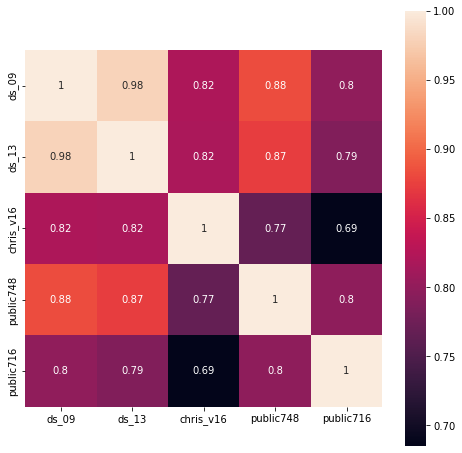

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.corr(), square=True, annot=True)
plt.show()

# Error analysis

In [13]:
prediction_df['rank_std'] = prediction_df.rank(0).std(1)

<AxesSubplot:xlabel='rank_std', ylabel='Count'>

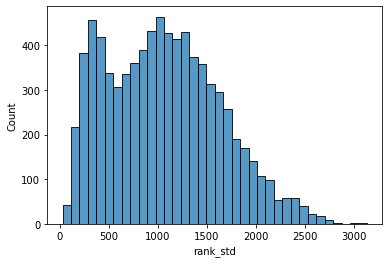

In [14]:
sns.histplot(prediction_df['rank_std'])

In [15]:
prediction_df = pd.concat([prediction_df, test], axis=1)

In [16]:
prediction_df_easy = prediction_df.sort_values('rank_std')
Path('input/plot/easy/').mkdir(parents=True, exist_ok=True)
ds = G2Net2022Dataset3(
    prediction_df_easy.head(100),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    # transforms=ClipSignal(0, 1.5)
)
for idx, (specs, _) in enumerate(ds):
    gid = ds.df.iloc[idx]['id']
    labels = ds.df[model_names].iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
    col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
    plt.plot(specs[:, col_roi0, 0])
    plt.plot(specs[:, col_roi1, 1])
    plt.title(f'time slice ({col_roi0}/{col_roi1})')
    plt.subplot(1, 4, 4)
    row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
    row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
    plt.plot(specs[row_roi0, :, 0])
    plt.plot(specs[row_roi1, :, 1])
    plt.title(f'freq slice ({row_roi0}/{row_roi1})')
    plt.savefig(f'input/plot/easy/{gid}.png', facecolor='white')
    plt.close()
    # plt.show()


In [17]:
prediction_df_hard = prediction_df.sort_values('rank_std', ascending=False)
Path('input/plot/hard/').mkdir(parents=True, exist_ok=True)
ds = G2Net2022Dataset3(
    prediction_df_hard.head(100),
    # prediction_df.loc[prediction_df['id'].isin(["040b35321", "09d7ea37a", "081ee0aea", "025517630"])],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ClipSignal(0, 1.5)
    # transforms=A.Compose([
    #     ClipSignal(0, 1.5),
    #     BandNoise(strength=0.25, p=1.0)
    # ])
    # transforms=ClipSignal(0, 1)
    # transforms=BandNoise(p=1.0)
    # transforms=DeltaNoise(channel='both', strength=(500, 4000), p=1),
    # transforms=MixupChannel(fix_area=True, p=1),
    # transforms=MixupChannel2(256, p=1)
)
for idx, (specs, _) in enumerate(ds):
    gid = prediction_df_hard.iloc[idx]['id']
    labels = prediction_df_hard[model_names].iloc[idx]
    plt.figure(figsize=(20, 6))
    plt.suptitle(f'{idx}, {np.round(labels.values, 2)}')
    plt.subplot(1, 4, 1)
    plt.imshow(specs[:, :, 0])
    plt.title('H1')
    plt.subplot(1, 4, 2)
    plt.imshow(specs[:, :, 1])
    plt.title('L1')
    plt.subplot(1, 4, 3)
    col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
    col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
    plt.plot(specs[:, col_roi0, 0])
    plt.plot(specs[:, col_roi1, 1])
    plt.title(f'time slice ({col_roi0}/{col_roi1})')
    plt.subplot(1, 4, 4)
    row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
    row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
    plt.plot(specs[row_roi0, :, 0])
    plt.plot(specs[row_roi1, :, 1])
    plt.title(f'freq slice ({row_roi0}/{row_roi1})')
    plt.savefig(f'input/plot/hard/{gid}.png', facecolor='white')
    plt.close()
    # plt.show()

In [18]:
# ds = G2Net2022Dataset3(
#     prediction_df.query('max_h1 < 350').sort_values('25%_h1', ascending=False).head(5),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     transforms=ClipSignal(0, 1.5)
# )
# for idx, (specs, _) in enumerate(ds):
#     gid = ds.df.iloc[idx]['id']
#     labels = ds.df[model_names].iloc[idx].values
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}, {np.round(labels, 2)}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
#     col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
#     plt.plot(specs[:, col_roi0, 0])
#     plt.plot(specs[:, col_roi1, 1])
#     plt.title(f'time slice ({col_roi0}/{col_roi1})')
#     plt.subplot(1, 4, 4)
#     row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
#     row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
#     plt.plot(specs[row_roi0, :, 0])
#     plt.plot(specs[row_roi1, :, 1])
#     plt.title(f'freq slice ({row_roi0}/{row_roi1})')
#     plt.show()

In [19]:
# ds = G2Net2022Dataset3(
#     pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v13.csv').query('base_id == "3bcc523a3"'),
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v13'),
#     preprocess=A.Compose([ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     transforms=A.Compose([
#         CropImage(256), 
#         # InjectTimeNoise('input/timenoise_v1.pickle', resize_factor=16, strength=(0.9, 1.5), p=1.),
#         # InjectAnomaly('input/anomaly_v0_16.pickle', 'H1', p=1.),
#         # InjectAnomaly('input/anomaly_v0_16.pickle', 'L1', p=1.)
#         ])
# )
# for idx, (specs, _) in enumerate(ds):
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[:, :, 0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[:, :, 1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     col_roi0 = np.argmax(specs[:, :, 0].std(axis=0))
#     col_roi1 = np.argmax(specs[:, :, 1].std(axis=0))
#     plt.plot(specs[:, col_roi0, 0])
#     plt.plot(specs[:, col_roi1, 1])
#     plt.title(f'time slice ({col_roi0}/{col_roi1})')
#     plt.subplot(1, 4, 4)
#     row_roi0 = np.argmax(specs[:, :, 0].std(axis=1))
#     row_roi1 = np.argmax(specs[:, :, 1].std(axis=1))
#     plt.plot(specs[row_roi0, :, 0])
#     plt.plot(specs[row_roi1, :, 1])
#     plt.title(f'freq slice ({row_roi0}/{row_roi1})')
#     plt.show()

# Analyse artifact

In [ ]:
from torchvision.ops import masks_to_boxes
import cv2

In [ ]:
anomaly_h1 = [
    "5b3eb27e1", "7ee0a00f8", '55dd4d584', '67e294a77', '80b695868', '1739abf41',
    '698567d90', '6735074ac', 'acc728828', 'b7ec2f672', 'b69313a43', 'b0990161d',
    'b95698658', 'fd0bde745', 'fe3005e83', '17ed59f7a', '38a84a185', '040b35321',
    'c5cd03dc9'
    ]
anomaly_l1 = ['8b180f74f', 'a1f9b8e82', 'dc2aaaee9', 'dee7c8d0f', 'f00d2044a']

In [ ]:
# ds = G2Net2022Dataset3(
#     test.loc[test['id'].isin(anomaly_h1+anomaly_l1)],
#     data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
#     preprocess=A.Compose([
#         ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
#     transforms=ToTensorV2()
# )
# for idx, (specs, _) in enumerate(ds):
#     gid = ds.df.iloc[idx]['id']
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx} {gid}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     plt.plot(specs[0, :, 128])
#     plt.plot(specs[1, :, 128])
#     plt.title('time slice')
#     plt.subplot(1, 4, 4)
#     plt.plot(specs[0, 180, :])
#     plt.plot(specs[1, 180, :])
#     plt.title('freq slice')
#     plt.show()

In [ ]:
def get_anomaly(spec, threshold=1.5):
    anomaly_mask = spec > threshold
    if anomaly_mask.sum() > 0:
        anomaly_bbox = masks_to_boxes(anomaly_mask[None, :, :])[0]
        xmin, ymin, xmax, ymax = anomaly_bbox.to(int)
        return spec[
            max(ymin-5, 0):min(ymax+5, spec.shape[1]), 
            max(xmin-5, 0):min(xmax+5, spec.shape[0])]
    else:
        None


def parse_anomaly(anomaly):
    anomaly = anomaly.numpy()
    anomaly[anomaly < 0.5] = 0
    strength = anomaly.max()
    anomaly = (anomaly - anomaly.min()) / (anomaly.max() - anomaly.min())
    return anomaly, strength

In [ ]:
anomaly_dict = {
    'H1': [], 'L1': []
}

In [ ]:
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(anomaly_h1)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ToTensorV2()
)

for specs, _ in ds:
    anomaly = get_anomaly(specs[0], 1.5)
    if anomaly is not None:
        if anomaly.shape[0] * anomaly.shape[1] < 1500:
            continue
        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.imshow(specs[0])
        # plt.subplot(1, 2, 2)
        # plt.imshow(anomaly)
        # plt.show()
        anomaly, strength = parse_anomaly(anomaly)
        if anomaly is not None:
            anomaly_dict['H1'].append((anomaly, strength))

In [ ]:
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(anomaly_l1)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), AdaptiveResize(16), NormalizeSpectrogram('constant')]),
    transforms=ToTensorV2()
)

for specs, _ in ds:
    anomaly = get_anomaly(specs[1], 1.5)
    if anomaly is not None:
        if anomaly.shape[0] * anomaly.shape[1] < 1500:
            continue
        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.imshow(specs[0])
        # plt.subplot(1, 2, 2)
        # plt.imshow(anomaly)
        # plt.show()
        anomaly, strength = parse_anomaly(anomaly)
        if anomaly is not None:
            anomaly_dict['L1'].append((anomaly, strength))

In [ ]:
with open('input/anomaly_v0_16.pickle', 'wb') as f:
    pickle.dump(anomaly_dict, f)

# Generate Noise Template

In [ ]:
timenoise_idx = [
    # v0
    '0a9ab0c9e', '0de7c7655', '0e9c2bb33', '1dc9bc740', '1facb0bab', '6b4107dfd', 
    '6ba4c8187', '6ec448e76', '7a1668972', '7dc03113e', '8bfb5c3fe', '8c0e4381a',
    '8f0d3c49c', '64bf3b4cc', '80ce2df12', '250ce99ba', '343fd1262', '371a20194',
    '439ff8b8c', '500ca9751', '838ca3d9e', '8537d2f36', '8603bf1e2', '961624e88',
    '2705507a9', '5310205bd', '38994676c', '82991740d', '227585724', 'a0eeec887',
    'ae967aea1', 'b4c72f14d', 'b176dfe31', 'b267c820d', 'b383cdb39', 'b604b31b5',
    'cdc0d65cb', 'cdeb7fe4a', 'd5b7bf6e3', 'd94f90817', 'e2c46e48a', 'e0696d220',
    'ef559e2d9', 'efb2e3891', 'f090b5877', 
    # v1
    '3da1e0f33', '9c0b5f798', '1928ca4a7', 'a9e280d75', 'dcdf0f575', 
    # v2
    '64a563381', 'df7f170d3', '0a1a06b36', '3bcc523a3', 'e4d6595d9',
    'd93435874', 'b829c1194', '65e192431', 'ceafe2326', 'da86f97af',
    '1b96f2483', 'b7a3bfd36', '5ffa7a8f4', '41154b5f0', '2dbea30b0',
    'd794f8f4e', 'd4e46b35f', '634543900'
]
timenoise_idx = set(timenoise_idx)
ds = G2Net2022Dataset3(
    test.loc[test['id'].isin(timenoise_idx)],
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'),
    preprocess=A.Compose([
        ToSpectrogram(), NormalizeSpectrogram('constant')]),
)

In [ ]:
def extract_noise_template(specs):
    spec_h1, specs_l1 = specs[:, :, 0], specs[:, :, 1]
    return spec_h1.mean(0), specs_l1.mean(0)

In [ ]:
noise_templates = {
    'H1': [],
    'L1': [],
}
for idx, (specs, _) in enumerate(ds):
    tmp_h1, tmp_l1 = extract_noise_template(specs)
    noise_templates['H1'].append(tmp_h1)
    noise_templates['L1'].append(tmp_l1)


In [ ]:
with open('input/timenoise_v2.pickle', 'wb') as f:
    pickle.dump(noise_templates, f)

# Training visualization

In [6]:
from configs import *

In [7]:
cfg = Baseline1d()

In [18]:
ds = cfg.dataset(
    pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v12.csv').head(10),
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/v12'),
    # transforms=cfg.transforms['train'],
    transforms=A.Compose([
        RandomCrop(4096),
        BandPass(sr=2048),
        WaveToTensor()]),
    **cfg.dataset_params
)

In [19]:
# for idx, (specs, _) in enumerate(ds):
#     plt.figure(figsize=(20, 6))
#     plt.suptitle(f'{idx}')
#     plt.subplot(1, 4, 1)
#     plt.imshow(specs[0])
#     plt.title('H1')
#     plt.subplot(1, 4, 2)
#     plt.imshow(specs[1])
#     plt.title('L1')
#     plt.subplot(1, 4, 3)
#     plt.plot(specs[0, :, 128])
#     plt.plot(specs[1, :, 128])
#     plt.title(f'time slice')
#     plt.subplot(1, 4, 4)
#     plt.plot(specs[0, 180, :])
#     plt.plot(specs[1, 180, :])
#     plt.title(f'freq slice')
#     plt.show()
#     if idx == 10:
#         break
    

torch.Size([2, 4096])


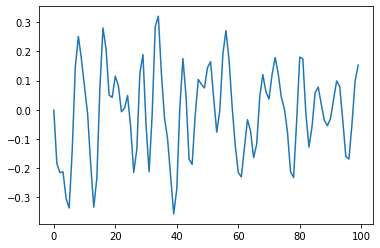

In [21]:
for idx, (wave, _) in enumerate(ds):
    print(wave.shape)
    plt.plot(wave[0, :100])
    plt.show()
    break
    